In [1]:
!pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 43.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import shapely.geometry as sgeom
from sklearn.preprocessing import LabelEncoder




In [3]:
eruptions = pd.read_csv('https://raw.githubusercontent.com/JoeRuggieroStudent/ML_Projects/main/eruptions.csv')


# Introduction to my dataset
This dataset ("eruptions") is a non-comprehensive list of over 11,000 volcanic eruptions through the historical record going back to ~1850.  The dataset contains the name of each volcano, the start year and month, the category of eruption, the VEI (volcanic explosivity index) the evidence for the volcano, and the location of each.  I would not consider this dataset "big data", but it is large, and I am hoping we can run some interesting regression on these.  I really picked this one for the regression module because acts almost as a time series, in which we can compare the amount of eruptions over time in context of a bunch of different variables (with some caveats we will explore further down).  I hope to use several kinds of regression to explore this large dataset.  Some interesting questions I can answer:
1. Is there a time of year that volcanoes happen?
2. Is there a specific year in this dataset that had more volcanoes? If so, why?
3. Is there a specific location on Earth where the most explosive volcanoes occur?
4. How long do volcanoes usually last?
5.  Is there any kind of cyclicity to eruptions that can be observed in this record?
6.  There is also an interesting column called 'evidence_method_dating', which refers to how we know a volcanic eruption occurred.  Most of the dataset is recorded by historical observations (basically someone seeing it happening), but there are a bunch of samples that are recorded by radiocarbon, tephra layers, and sediment varves.  It will be interesting to examine those samples specifically and see if they are concentrated in any particular areas or times.

We'll hold off answering those exciting questions for now, and here focus on some exploratory data analysis.


#Part 1: Exploratory Data Analysis

In [4]:
eruptions.head()

,volcano_number,volcano_name,eruption_number,eruption_category,area_of_activity,vei,start_year,start_month,start_day,evidence_method_dating,end_year,end_month,end_day,latitude,longitude
0,266030,Soputan,22354,Confirmed Eruption,NaN,NaN,2020.0,3.0,23.0,Historical Observations,2020.0,4.0,2.0,1.112,124.737
1,343100,San Miguel,22355,Confirmed Eruption,NaN,NaN,2020.0,2.0,22.0,Historical Observations,2020.0,2.0,22.0,13.434,-88.269
2,233020,"Fournaise, Piton de la",22343,Confirmed Eruption,NaN,NaN,2020.0,2.0,10.0,Historical Observations,2020.0,4.0,6.0,-21.244,55.708
3,345020,Rincon de la Vieja,22346,Confirmed Eruption,NaN,NaN,2020.0,1.0,31.0,Historical Observations,2020.0,4.0,17.0,10.830,-85.324
4,353010,Fernandina,22347,Confirmed Eruption,NaN,NaN,2020.0,1.0,12.0,Historical Observations,2020.0,1.0,12.0,-0.370,-91.550


#Eruptions.shape

In [5]:
eruptions.shape

(11178, 15)

In [6]:
eruptions.columns

Index(['volcano_number', 'volcano_name', 'eruption_number',
       'eruption_category', 'area_of_activity', 'vei', 'start_year',
       'start_month', 'start_day', 'evidence_method_dating', 'end_year',
       'end_month', 'end_day', 'latitude', 'longitude'],
      dtype='object')

This dataset has 11,178 rows and 15 columns describing volcanic eruptions

#Eruptions.describe

In [7]:
eruptions.describe()

,volcano_number,eruption_number,vei,start_year,start_month,start_day,end_year,end_month,end_day,latitude,longitude
count,11178.000000,11178.000000,8272.000000,11177.000000,10985.000000,10982.000000,4332.000000,4329.000000,4326.000000,11178.000000,11178.000000
mean,300284.371176,15666.905439,1.947897,622.848260,3.450888,7.015025,1917.326639,6.220836,13.315996,16.865778,31.572377
std,52321.193203,3297.612433,1.161098,2482.174317,4.071419,9.645386,157.646408,3.686128,9.831282,30.761752,115.248384
min,210010.000000,10001.000000,0.000000,-11345.000000,0.000000,0.000000,-475.000000,0.000000,0.000000,-77.530000,-179.970000
25%,263310.000000,12817.250000,1.000000,680.000000,0.000000,0.000000,1895.000000,3.000000,4.000000,-6.102000,-77.656000
50%,290050.000000,15650.500000,2.000000,1847.000000,1.000000,0.000000,1957.000000,6.000000,15.000000,17.600000,55.708000
75%,343030.000000,18463.750000,2.000000,1950.000000,7.000000,15.000000,1992.000000,9.000000,21.000000,40.821000,139.394000
max,600000.000000,22355.000000,7.000000,2020.000000,12.000000,31.000000,2020.000000,12.000000,31.000000,85.608000,179.580000


eruptions.describe() is not the most descriptive for this dataset, as each sample here represents a different point count in a different location at a different time.  Therefore, knowing the average isn't that useful for these data (except for VEI, which tells us that the average volcano through time has had a VEI of 1.95, which is not insignificant.

#Seaborn Pairplot
Let's first visualize and compare the numeric data columns in a pairplot

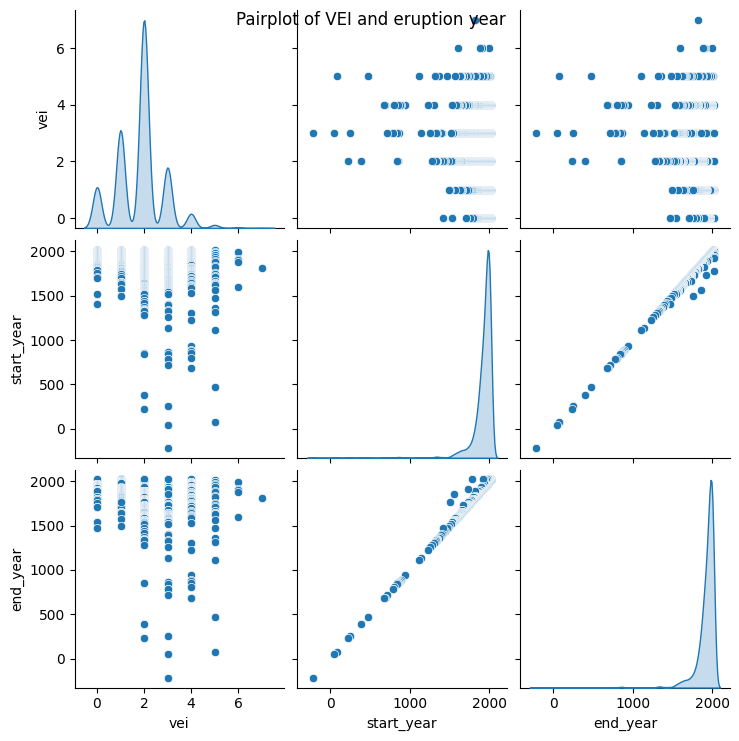

In [8]:
# Selecting numeric columns for pairplot
num_cols = ['vei', 'start_year', 'end_year']

# Drop rows with missing values in selected columns
eruptions_numeric = eruptions[num_cols].dropna()

# Create the pairplot
sns.pairplot(eruptions_numeric, diag_kind='kde', corner=False)
plt.suptitle("Pairplot of VEI and eruption year")
# Show the plot
plt.show()


It's a bit weird for this kind of data.  There appears to be some visual clustering regarding year and VEI, but nothing major.  Most observed volcanoes appear to be between 1500 and 2000, which makes sense.  The closer we get to modern the more observational data there will be.  It also appears that the most common VEI is 2, which is close to the mean we found above.

#Pearson Correlation Matrix

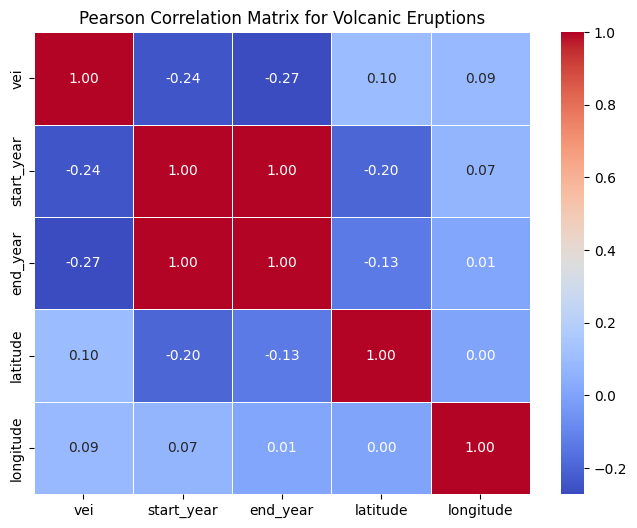

In [9]:
#Establish columns for correlation matrix
corr_col = ['vei', 'start_year', 'end_year', 'latitude', 'longitude']

# Compute the correlation matrix
corr_matrix = eruptions[corr_col].corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Title
plt.title("Pearson Correlation Matrix for Volcanic Eruptions")

# Show the plot
plt.show()


We are looking only at a few numeric variables here, none of which seem correlated, except for start year and end year.  So far it is not looking like there is any connection between VEI and location.


#VEI histogram


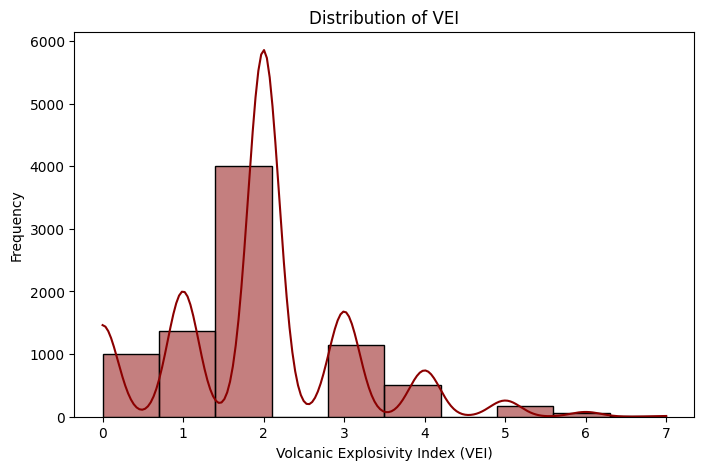

In [10]:
# Set figure size
plt.figure(figsize=(8, 5))

# Create the histogram
sns.histplot(eruptions['vei'].dropna(), bins=10, kde=True, color='darkred')

# Labels and title
plt.xlabel("Volcanic Explosivity Index (VEI)")
plt.ylabel("Frequency")
plt.title("Distribution of VEI")

# Show the plot
plt.show()


We already cursorily examined this in the pair plot, but I wanted to take some more devout focus on VEI, which ranks the power of the eruption.  It seems like VEI index of 2 is much more common than any of the other magnitudes.

#Number of eruptions per year
Next, let's examine the number of eruptions per year.  We did this for the whole dataset in the pairplot, which gave us the following output:

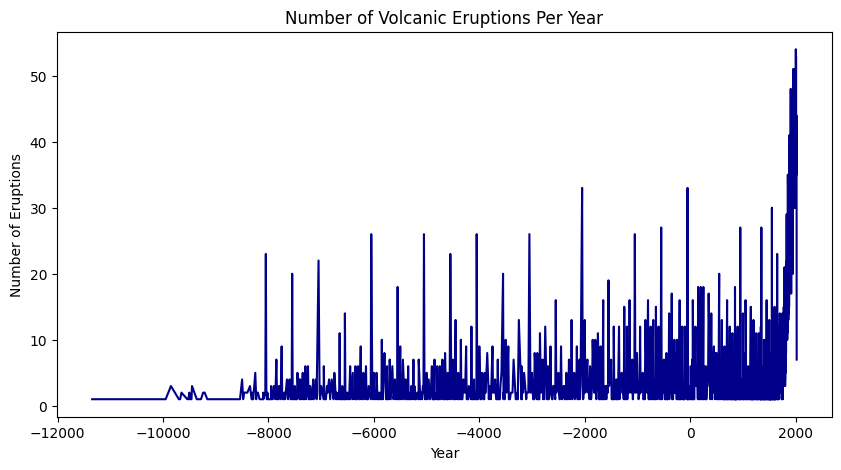

In [11]:
# Count eruptions per year
eruptions_per_year = eruptions['start_year'].value_counts().sort_index()

# Plot the trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=eruptions_per_year.index, y=eruptions_per_year.values, color='darkblue')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Eruptions")
plt.title("Number of Volcanic Eruptions Per Year")

# Show the plot
plt.show()


Its a bit hard to see, so lets try to smooth this a bit with a rolling average:

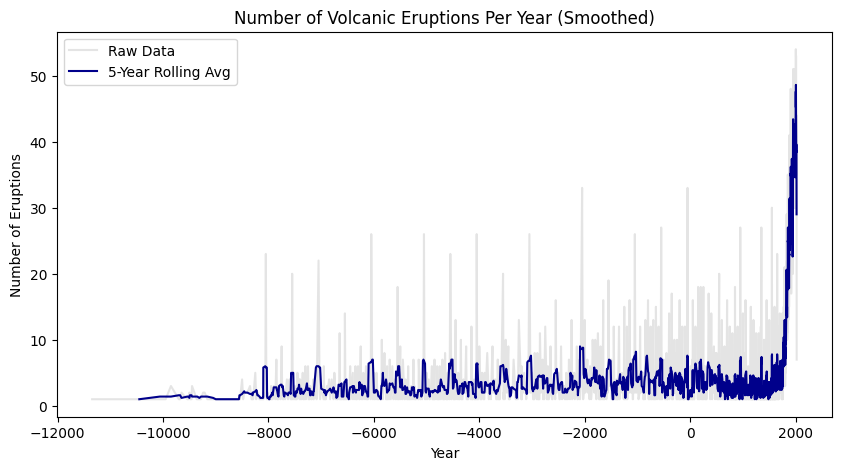

In [12]:
# Compute yearly eruption counts
eruptions_per_year = eruptions['start_year'].value_counts().sort_index()

# Apply a rolling average (window=5 for a 5-year smoothing)
rolling_eruptions = eruptions_per_year.rolling(window=5, center=True).mean()

# Plot the trend with smoothing
plt.figure(figsize=(10, 5))
sns.lineplot(x=eruptions_per_year.index, y=eruptions_per_year.values, label="Raw Data", color='lightgray', alpha=0.6)
sns.lineplot(x=rolling_eruptions.index, y=rolling_eruptions.values, label="5-Year Rolling Avg", color='darkblue')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Eruptions")
plt.title("Number of Volcanic Eruptions Per Year (Smoothed)")

# Show the plot
plt.show()


There are so many more eruptions in the historical record, especially as we approach yr 2000.  But lets zoom in a bit, and examine number of eruptions in hundred year increments between 1500 and 2025, which is when most of the eruptions have happened:

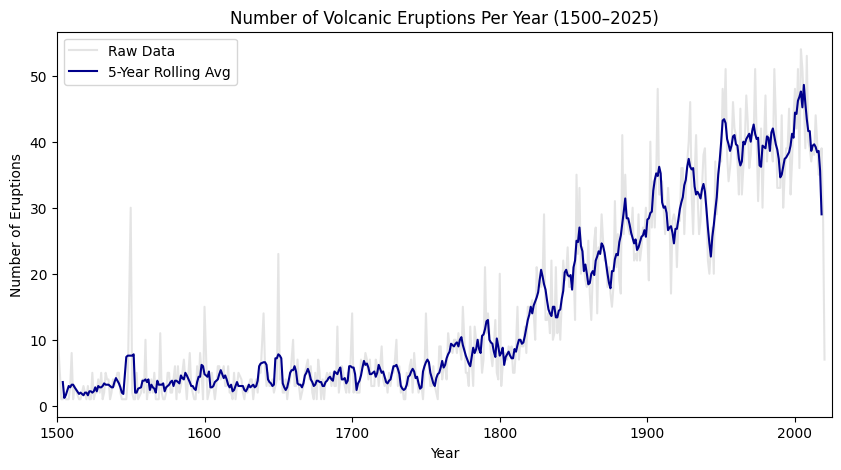

In [13]:
# Filter data for years between 1500 and 2025
filtered_eruptions = eruptions[(eruptions['start_year'] >= 1500) & (eruptions['start_year'] <= 2025)]

# Compute yearly eruption counts
eruptions_per_year = filtered_eruptions['start_year'].value_counts().sort_index()

# Apply a rolling average (5-year smoothing)
rolling_eruptions = eruptions_per_year.rolling(window=5, center=True).mean()

# Plot the trend with smoothing
plt.figure(figsize=(10, 5))
sns.lineplot(x=eruptions_per_year.index, y=eruptions_per_year.values, label="Raw Data", color='lightgray', alpha=0.6)
sns.lineplot(x=rolling_eruptions.index, y=rolling_eruptions.values, label="5-Year Rolling Avg", color='darkblue')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Eruptions")
plt.title("Number of Volcanic Eruptions Per Year (1500–2025)")

# Set x-axis limits
plt.xlim(1500, 2025)

# Show the plot
plt.show()


Again, we see an increase in the amount of eruptions occuring after 1800.  This is not reflecting an increase in eruption rates, but rather an increase in observation as the world became more globalized and people starting paying closer attention.  The amount of eruptions appear to level out around 1950, which suggests to me that the scientific community was now looking globally and are recording most volcanoes that happen, so lets examine that dataset closer next:

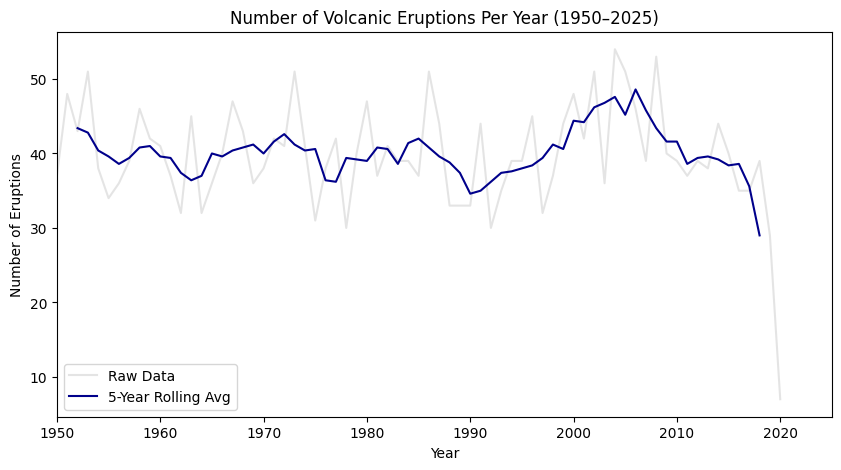

In [14]:
# Filter data for years between 1500 and 2025
filtered_eruptions = eruptions[(eruptions['start_year'] >= 1950) & (eruptions['start_year'] <= 2025)]

# Compute yearly eruption counts
eruptions_per_year = filtered_eruptions['start_year'].value_counts().sort_index()

# Apply a rolling average (5-year smoothing)
rolling_eruptions = eruptions_per_year.rolling(window=5, center=True).mean()

# Plot the trend with smoothing
plt.figure(figsize=(10, 5))
sns.lineplot(x=eruptions_per_year.index, y=eruptions_per_year.values, label="Raw Data", color='lightgray', alpha=0.6)
sns.lineplot(x=rolling_eruptions.index, y=rolling_eruptions.values, label="5-Year Rolling Avg", color='darkblue')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Eruptions")
plt.title("Number of Volcanic Eruptions Per Year (1950–2025)")

# Set x-axis limits
plt.xlim(1950, 2025)

# Show the plot
plt.show()


This type of questioning will be interesting for regressions and looking for cycles and trends through time.

#Geographic Distribution of Eruption by size
Next, I am curious if there is any kind of spatial relationship between these datasets.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


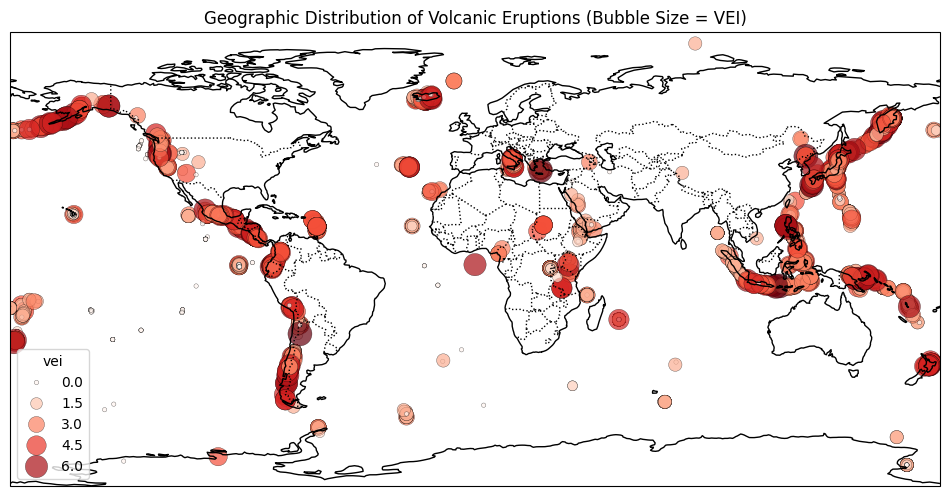

In [15]:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the map
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot eruptions as bubbles (scatter plot)
sns.scatterplot(
    data=eruptions,
    x="longitude",
    y="latitude",
    size="vei",
    sizes=(10, 300),  # Adjusts bubble size range
    hue="vei",
    palette="Reds",
    alpha=0.7,
    edgecolor="black",
    ax=ax  # Plot on the Cartopy axis
)

# Add title and labels
plt.title("Geographic Distribution of Volcanic Eruptions (Bubble Size = VEI)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()




Okay we have now successfully generated a very common map.  we can see the entire Pacific Ring of Fire that wraps its way around the Pacific continental margin.  We can almost see the Mid-Atlantic Ridge, and interestingly only small volcanes are observed in the middle of the ocean.  We can also visualize the frequency of eruptions this way, and see where the most common eruptions occur.  It appears that Italy, Patagonia, South Asia, and just off the coast of Madagascar is most common.

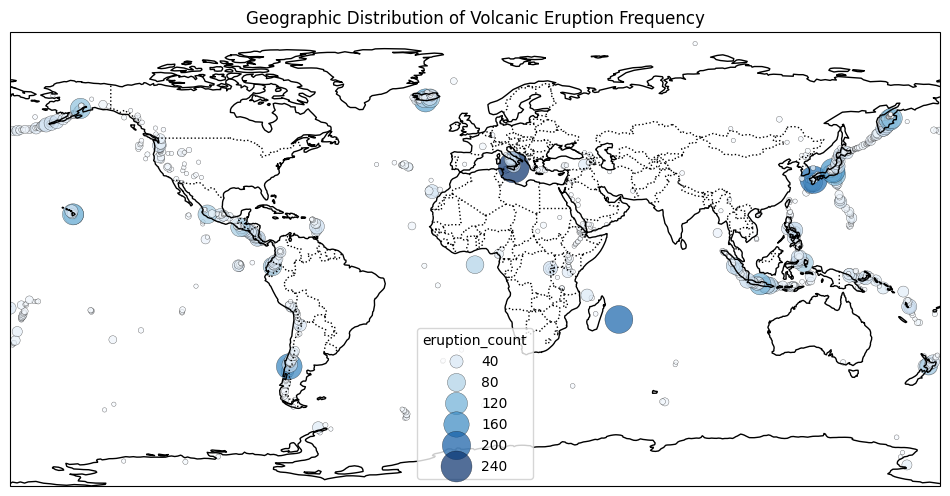

In [16]:
# Group eruptions by rounded latitude and longitude for heatmap-like regions
# Round to a specific level for grouping (e.g., 1 degree)
eruptions['lat_round'] = eruptions['latitude'].round(1)
eruptions['lon_round'] = eruptions['longitude'].round(1)

# Count the number of eruptions in each (lat, lon) group
eruption_counts = eruptions.groupby(['lat_round', 'lon_round']).size().reset_index(name='eruption_count')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the map
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot eruptions as bubbles (scatter plot)
sns.scatterplot(
    data=eruption_counts,
    x="lon_round",
    y="lat_round",
    size="eruption_count",
    sizes=(10, 500),  # Adjust bubble size range
    hue="eruption_count",
    palette="Blues",  # Change palette for frequency
    alpha=0.7,
    edgecolor="black",
    ax=ax  # Plot on the Cartopy axis
)

# Add title and labels
plt.title("Geographic Distribution of Volcanic Eruption Frequency")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


# Most active volcanoes
Finally, lets examine the most active volcanoes:

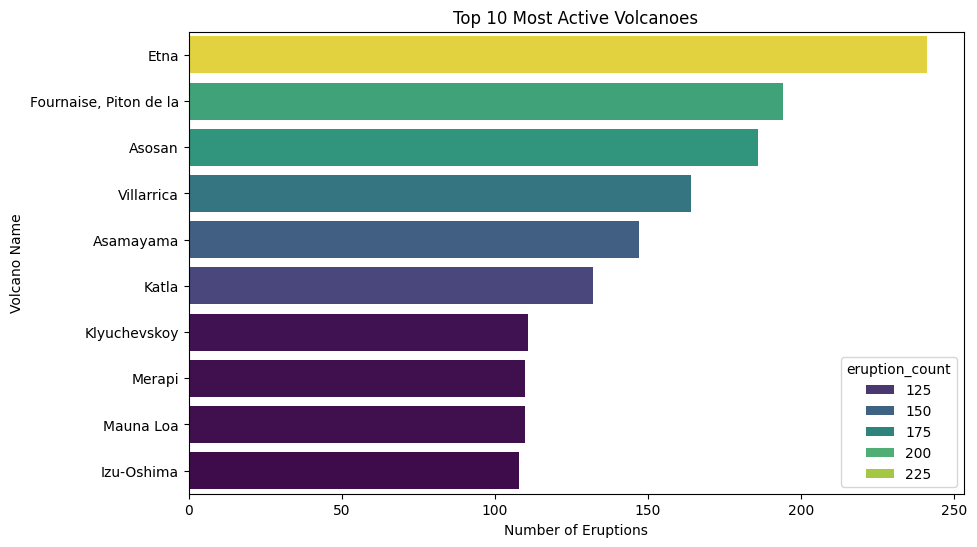

In [17]:

# Group the data by volcano and count the number of eruptions
volcano_activity = eruptions.groupby('volcano_name').size().reset_index(name='eruption_count')

# Sort volcanoes by eruption count in descending order
volcano_activity_sorted = volcano_activity.sort_values(by='eruption_count', ascending=False)

# Get the top 10 most active volcanoes
top_10_volcanoes = volcano_activity_sorted.head(10)

# Plot the top 10 most active volcanoes
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_volcanoes,
    x='eruption_count',
    y='volcano_name',
    palette='viridis',
    hue='eruption_count'
)

# Add titles and labels
plt.title("Top 10 Most Active Volcanoes")
plt.xlabel("Number of Eruptions")
plt.ylabel("Volcano Name")

# Show the plot
plt.show()


It looks like this list got us pretty close to the map of volcano frequency we made earlier.  In the rest of this module, I will be running a series of regressions on frequency, location, magnitude, and more on these eruptions.

#Part 2: Supervised Regression

My main goal in this exercise is to see if I can predict VEI based off of variables obtainable from this dataset.  If successful, I want to see if there are important variables that predict VEI.

## Can you predict the VEI of an eruption based on the volcano characteristics?

This question is an important one involving volcanic explosivity.  Here, I am curious to see basically if VEI can be predicted.  We have several variables that might provide insight, including lat/long, the volcano itself, and area of activity.

Because VEI is categorical, we need to classify an eruption into the VEI categories based off the data available in this dataset, which unfortunately is only volcano name and latitude and longitude.  So we can add another variable just based off this data.  While it would take a lot of work to classify these volcanoes based on tectonic setting, we should be able to easily classify them based off of if eruptions happen in the marine realm or terrestrial realm to add a bit more data to this analysis.  Let's do that now.  

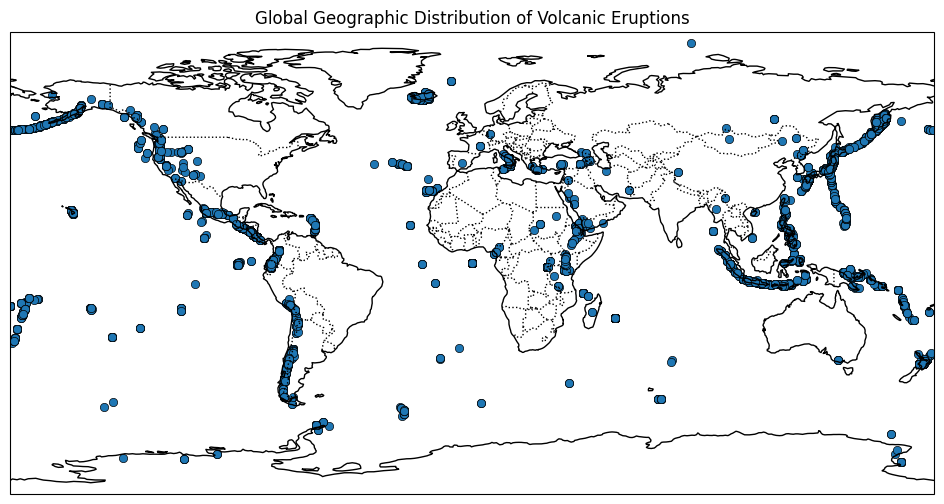

In [18]:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the map with global view
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot eruptions as dots (no VEI size)
sns.scatterplot(
    data=eruptions,
    x="longitude",
    y="latitude",
    edgecolor="black",
    marker="o",  # Simple dot marker
    ax=ax  # Plot on the Cartopy axis
)

# Add title and labels
plt.title("Global Geographic Distribution of Volcanic Eruptions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


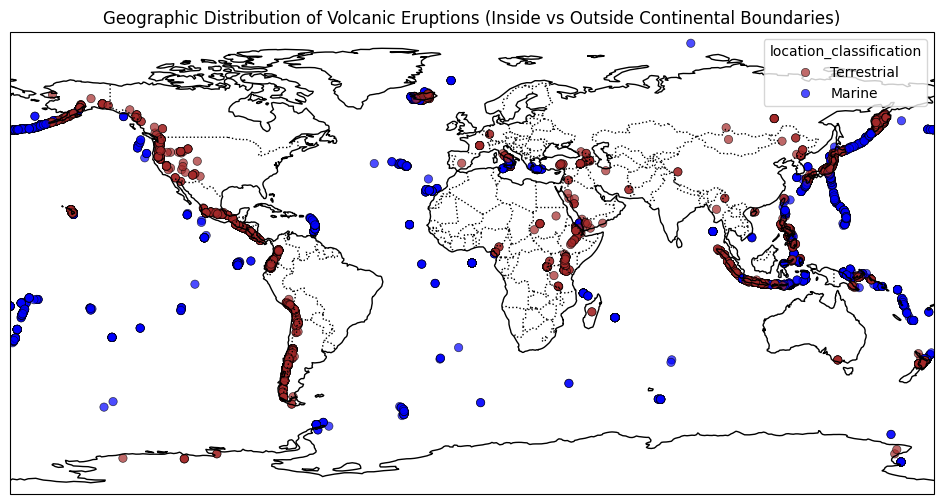

In [19]:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the map with global view
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Create a Cartopy feature for land (continents)
land = cfeature.LAND

# Function to check if a point is on land by comparing it with Cartopy's LAND feature
def is_on_land(lat, lon):
    # Create a shapely point for the given coordinates
    point = sgeom.Point(lon, lat)

    # Check if the point falls within the land boundaries
    for land_feature in land.geometries():
        if land_feature.contains(point):
            return True
    return False

# Classify eruptions based on whether they are on land
eruptions['location_classification'] = eruptions.apply(
    lambda row: 'Terrestrial' if is_on_land(row['latitude'], row['longitude']) else 'Marine', axis=1
)

# Plot eruptions with classification
sns.scatterplot(
    data=eruptions,
    x="longitude",
    y="latitude",
    hue="location_classification",  # Color by classification (Inside or Outside)
    palette={"Terrestrial": "brown", "Marine": "blue"},  # Color scheme for classification
    alpha=0.7,
    edgecolor="black",
    marker="o",  # Simple dot marker
    ax=ax  # Plot on the Cartopy axis
)

# Add title and labels
plt.title("Geographic Distribution of Volcanic Eruptions (Inside vs Outside Continental Boundaries)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


This did a pretty good job! Green means the eruption happened on land and red means it happened in the ocean.  Let's add them to our dataset

In [20]:
# Classify eruptions based on whether they are on land
eruptions['location_classification'] = eruptions.apply(
    lambda row: 'Terrestrial' if is_on_land(row['latitude'], row['longitude']) else 'Marine', axis=1
)

# Now the eruptions DataFrame will have a new column 'location_classification' with updated labels
# You can check the first few rows to verify:
print(eruptions[['volcano_name', 'latitude', 'longitude', 'location_classification']].head())


             volcano_name  latitude  longitude location_classification
0                 Soputan     1.112    124.737             Terrestrial
1              San Miguel    13.434    -88.269             Terrestrial
2  Fournaise, Piton de la   -21.244     55.708                  Marine
3      Rincon de la Vieja    10.830    -85.324             Terrestrial
4              Fernandina    -0.370    -91.550                  Marine


Let's also add geographic region to this.  There are about 1000 ways that we could subdivide the world into different regions, so to keep it simple, lets classify each eruption into a global quadrant.

In [21]:
def classify_quadrant_with_labels(row):
    lat, lon = row['latitude'], row['longitude']

    if lat >= 0 and lon >= 0:
        return 'Northeast'  # Q1: Northern Hemisphere, Eastern Hemisphere
    elif lat >= 0 and lon < 0:
        return 'Northwest'  # Q2: Northern Hemisphere, Western Hemisphere
    elif lat < 0 and lon < 0:
        return 'Southwest'  # Q3: Southern Hemisphere, Western Hemisphere
    elif lat < 0 and lon >= 0:
        return 'Southeast'  # Q4: Southern Hemisphere, Eastern Hemisphere
    else:
        return 'Unknown'

# Apply function to classify eruptions into labeled quadrants
eruptions['quadrant_label'] = eruptions.apply(classify_quadrant_with_labels, axis=1)

# Check the first few rows to verify
print(eruptions[['volcano_name', 'latitude', 'longitude', 'quadrant_label']].head())


             volcano_name  latitude  longitude quadrant_label
0                 Soputan     1.112    124.737      Northeast
1              San Miguel    13.434    -88.269      Northwest
2  Fournaise, Piton de la   -21.244     55.708      Southeast
3      Rincon de la Vieja    10.830    -85.324      Northwest
4              Fernandina    -0.370    -91.550      Southwest


In [22]:
eruptions.head()

,volcano_number,volcano_name,eruption_number,eruption_category,area_of_activity,vei,start_year,start_month,start_day,evidence_method_dating,end_year,end_month,end_day,latitude,longitude,lat_round,lon_round,location_classification,quadrant_label
0,266030,Soputan,22354,Confirmed Eruption,NaN,NaN,2020.0,3.0,23.0,Historical Observations,2020.0,4.0,2.0,1.112,124.737,1.1,124.7,Terrestrial,Northeast
1,343100,San Miguel,22355,Confirmed Eruption,NaN,NaN,2020.0,2.0,22.0,Historical Observations,2020.0,2.0,22.0,13.434,-88.269,13.4,-88.3,Terrestrial,Northwest
2,233020,"Fournaise, Piton de la",22343,Confirmed Eruption,NaN,NaN,2020.0,2.0,10.0,Historical Observations,2020.0,4.0,6.0,-21.244,55.708,-21.2,55.7,Marine,Southeast
3,345020,Rincon de la Vieja,22346,Confirmed Eruption,NaN,NaN,2020.0,1.0,31.0,Historical Observations,2020.0,4.0,17.0,10.830,-85.324,10.8,-85.3,Terrestrial,Northwest
4,353010,Fernandina,22347,Confirmed Eruption,NaN,NaN,2020.0,1.0,12.0,Historical Observations,2020.0,1.0,12.0,-0.370,-91.550,-0.4,-91.6,Marine,Southwest


Okay, now that we have done this step, we can examine VEI based on global quadrant, volcano name, and whether or not is it a marine/terrestrial eruption.  
### Does volcanic environment (terrestrial vs marine) impact VEI?

Accuracy: 0.4731457800511509

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        89
         2.0       0.47      1.00      0.64       185
         3.0       0.00      0.00      0.00        64
         4.0       0.00      0.00      0.00        14
         5.0       0.00      0.00      0.00         2
         6.0       0.00      0.00      0.00         2

    accuracy                           0.47       391
   macro avg       0.07      0.14      0.09       391
weighted avg       0.22      0.47      0.30       391



<ipython-input-23-a846ea3da776>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eruptions_cleaned['location_classification_encoded'] = le.fit_transform(eruptions_cleaned['location_classification'])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

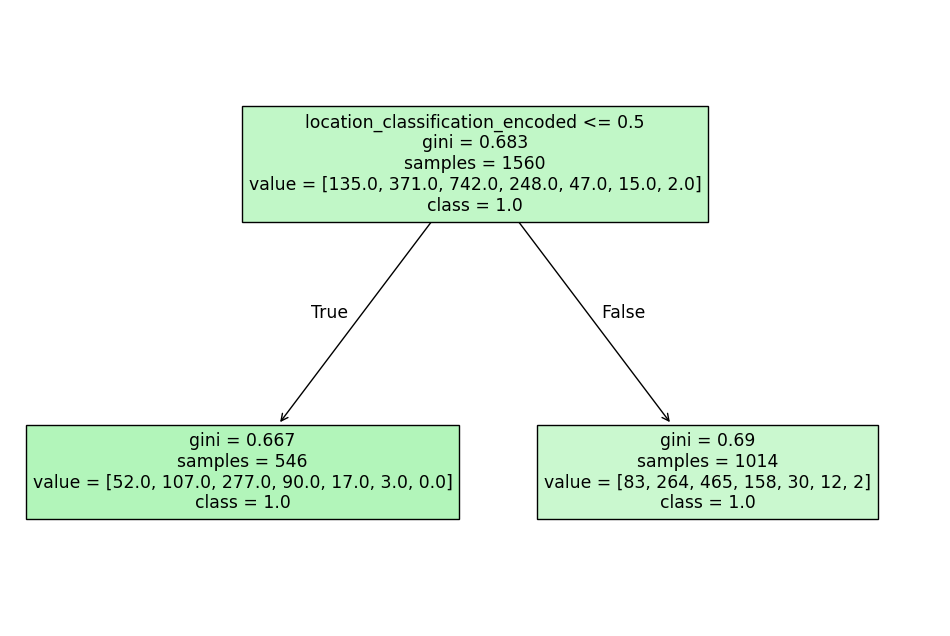

In [23]:
eruptions_cleaned = eruptions.dropna()  # or eruptions.fillna(value)

# Prepare the data: Encode 'location_classification' as numeric (Terrestrial = 1, Marine = 0)
le = LabelEncoder()
eruptions_cleaned['location_classification_encoded'] = le.fit_transform(eruptions_cleaned['location_classification'])

# Prepare the feature (X) and target (y)
X = eruptions_cleaned[['location_classification_encoded']]  # Only location classification as feature
y = eruptions_cleaned['vei']

# Drop rows with missing values in target or feature
X = X.dropna()
y = y[X.index]  # Ensure alignment of X and y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optionally visualize the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=['location_classification_encoded'], class_names=[str(cls) for cls in y.unique()], filled=True)
plt.show()


Just based off this simple test, it doesn't appear that eruption environment has any relationship with VEI, classes are not being correctly identified except for VEI 2, although it has really poor precistion.  VEI 2 is the most common eruption category, so it actually makes sense that if you were to take a random guess, there is a chance you would correctly identify VEI 2.  If we add another feature in, lets see if we can get any more resolution to this question by adding in the year of the eruption:

In [24]:

# Handle missing values if necessary (for year, for instance)
eruptions_cleaned = eruptions.dropna(subset=['location_classification', 'start_year', 'vei'])

# Convert 'location_classification' to numeric (binary: Terrestrial = 1, Marine = 0)
eruptions_cleaned['location_classification_num'] = eruptions_cleaned['location_classification'].apply(
    lambda x: 1 if x == 'Terrestrial' else 0
)

# We can use year as-is, but ensure it's numeric if there are any issues with it
eruptions_cleaned['start_year'] = pd.to_numeric(eruptions_cleaned['start_year'], errors='coerce')

# Drop any remaining rows with missing year values after conversion
eruptions_cleaned = eruptions_cleaned.dropna(subset=['start_year'])

# Step 2: Feature selection
X = eruptions_cleaned[['location_classification_num', 'start_year']]  # Features
y = eruptions_cleaned['vei']  # Target variable (VEI)

# Step 3: Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model - Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize the model
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Step 5: Predictions and Evaluation
y_pred = clf.predict(X_test)

# Classification report to evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.18      0.25      0.21       187
         1.0       0.33      0.25      0.28       289
         2.0       0.56      0.70      0.62       777
         3.0       0.23      0.11      0.15       227
         4.0       0.17      0.09      0.12       116
         5.0       0.11      0.04      0.06        45
         6.0       0.00      0.00      0.00        14
         7.0       0.00      0.00      0.00         0

    accuracy                           0.42      1655
   macro avg       0.20      0.18      0.18      1655
weighted avg       0.39      0.42      0.39      1655



<ipython-input-24-6a86d062c78c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eruptions_cleaned['location_classification_num'] = eruptions_cleaned['location_classification'].apply(
<ipython-input-24-6a86d062c78c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eruptions_cleaned['start_year'] = pd.to_numeric(eruptions_cleaned['start_year'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 

We're doing really poorly, so lets drop this approach.  To visualize this, lets try to do a regression between the two.  A linear regression is not really appropriate here because VEI and Location_Classification are both categorical variables, so we can do an ordinal regression and a logistic regression instead.  An ordinal regression will treat the target variable (the relationship) as ordered categories.  A logistic regression will place the eruptions VEI into a specific binary category.  Let's do a multi-class logistic regression

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       187
         1.0       0.00      0.00      0.00       289
         2.0       0.47      1.00      0.64       777
         3.0       0.00      0.00      0.00       227
         4.0       0.00      0.00      0.00       116
         5.0       0.00      0.00      0.00        45
         6.0       0.00      0.00      0.00        14

    accuracy                           0.47      1655
   macro avg       0.07      0.14      0.09      1655
weighted avg       0.22      0.47      0.30      1655



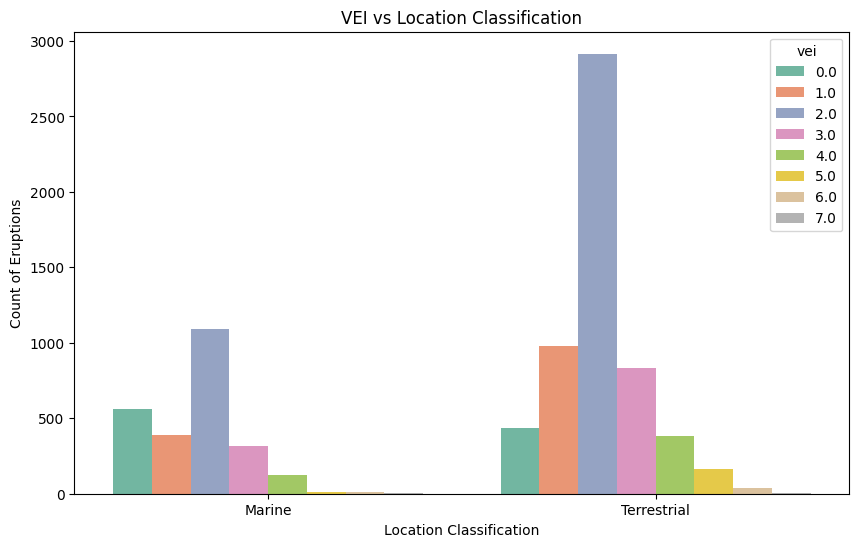

In [25]:

# Step 1: Encode the 'location_classification' column (binary: Terrestrial vs Marine)
encoder = LabelEncoder()
eruptions_cleaned['location_classification_encoded'] = encoder.fit_transform(eruptions_cleaned['location_classification'])

# Step 2: Prepare the features (X) and target (y)
X = eruptions_cleaned[['location_classification_encoded']]  # Only location_classification
y = eruptions_cleaned['vei']  # Target column (VEI)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Logistic Regression model (Multi-class)
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
print(classification_report(y_test, y_pred))

# Step 7: Visualize the results
plt.figure(figsize=(10, 6))
sns.countplot(data=eruptions_cleaned, x='location_classification', hue='vei', palette='Set2')
plt.title("VEI vs Location Classification")
plt.xlabel("Location Classification")
plt.ylabel("Count of Eruptions")
plt.show()


Even with the logistic regression, we are doing very poorly to classify this relationship.  This signifies to me that you cannot predict the VEI based on variables listed or derived from this dataset.  This may or may not be true.  Some specific domain knowledge would be great here to see if there actually is a way to predict VEI, but according to just my analysis so far, there is not.

So far we have tried decision tree and logistic regression.  Lets try one more thing.  Neural Networks are really high performing tools to evaluate complex relationships.  Lets try to to use one to classify VEI based on all of the variables we have so far.

In [26]:
eruptions.columns

Index(['volcano_number', 'volcano_name', 'eruption_number',
       'eruption_category', 'area_of_activity', 'vei', 'start_year',
       'start_month', 'start_day', 'evidence_method_dating', 'end_year',
       'end_month', 'end_day', 'latitude', 'longitude', 'lat_round',
       'lon_round', 'location_classification', 'quadrant_label'],
      dtype='object')

In [27]:

# Encode categorical columns (location_classification and quadrant)
encoder = LabelEncoder()
eruptions_cleaned['location_classification_encoded'] = encoder.fit_transform(eruptions_cleaned['location_classification'])
eruptions_cleaned['quadrant_encoded'] = encoder.fit_transform(eruptions_cleaned['quadrant_label'])

# Select relevant features (location_classification, quadrant, latitude, longitude) and target (VEI)
X = eruptions_cleaned[['location_classification_encoded', 'quadrant_encoded', 'latitude', 'longitude']]
y = eruptions_cleaned['vei']  # Target column (VEI)

# Handle missing values (e.g., filling with the mean for numerical columns)
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Scale the numerical columns (latitude and longitude)
scaler = StandardScaler()
X[['latitude', 'longitude']] = scaler.fit_transform(X[['latitude', 'longitude']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:

# Create a simple neural network model
model = Sequential()

# Input layer (number of features is the number of columns in X_train)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # First hidden layer
model.add(Dense(32, activation='relu'))  # Second hidden layer
model.add(Dense(1, activation='linear'))  # Output layer (since VEI is a continuous variable)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.4056 - val_loss: 1.3628
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2565 - val_loss: 1.3348
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2210 - val_loss: 1.3296
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2291 - val_loss: 1.2865
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1363 - val_loss: 1.2759
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1646 - val_loss: 1.2586
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1489 - val_loss: 1.2475
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1289 - val_loss: 1.2457
Epoch 9/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1624 - val_loss: 1.2352
Epoch 10/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0944 - val_loss: 1.2277
Epoch 11/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1417 - val_loss: 1.2242
Epoch 12/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1016 
Test loss: 1.1789741516113281


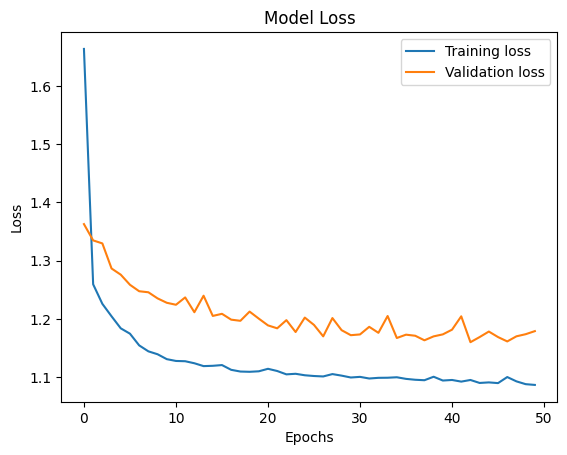

In [29]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


###**What did we do here?**
Here, we classified the variables quadrant, locations_classified, latitude, and longitude to try and predict VEI in a sample.  In this approach, we want to reduce "loss" with more training, measning we want prediction to be better.  In this case, loss is the Mean Squared Root Error.  Let's calculate some statistics on this

In [30]:

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R-squared: 0.17213118324287857


R2 value represents how well the model explaince the variance in the target vriable.  R2=0.17 indicates that the model does no better than just predicting the average of the data.

In [31]:

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.7604302592688097


Mean Absolute Error indicates the average magnitudes in prediction errors. Lower MAE indicates better performance, so 0.79 is pretty horrible.

In [32]:

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 1.1789741773020448


MSE indicates model error

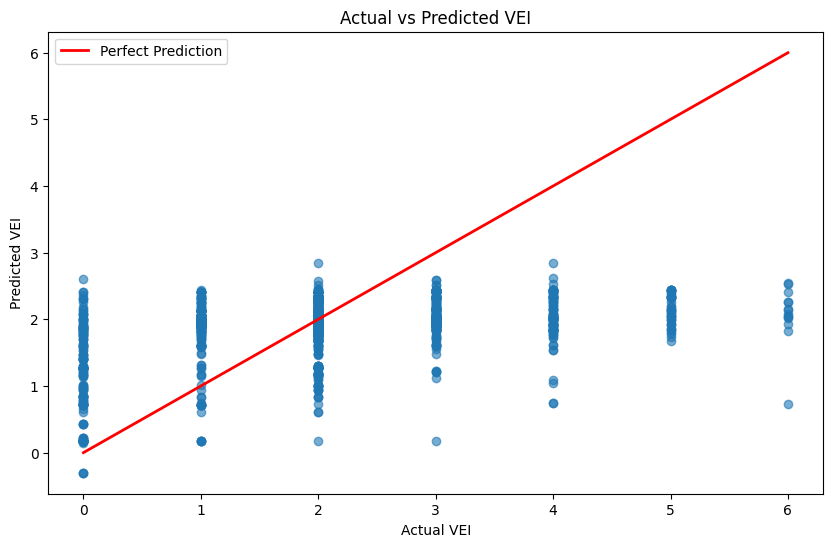

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label="Perfect Prediction")
plt.xlabel('Actual VEI')
plt.ylabel('Predicted VEI')
plt.title('Actual vs Predicted VEI')
plt.legend()
plt.show()


Our Neural Network also didn't do great. We could probably add more data in and parameterize some variables using outside data, but just based off of this dataset it does not appear possible to predict VEI off of these factors.  However, we are seeing an increase in model performance based off of loss, which means the model is categorizing the data in some kind of way that gets better with training.  Let's see what features are most important to try and get to the bottom of this using Permutation Importance

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


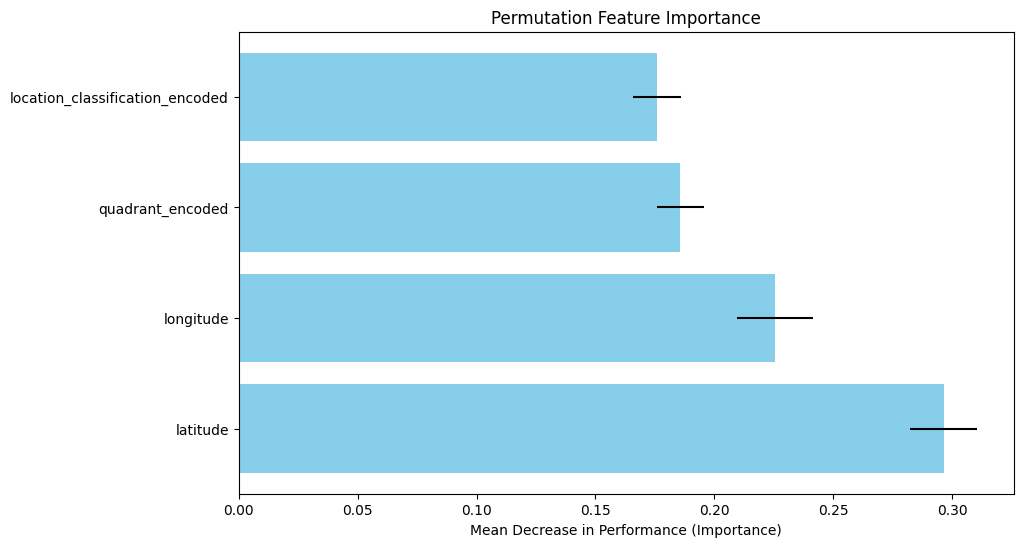

                           Feature  Importance   Std Dev
2                         latitude    0.296303  0.013936
3                        longitude    0.225501  0.015930
1                 quadrant_encoded    0.185571  0.009857
0  location_classification_encoded    0.175790  0.010030


In [34]:

# Step 1: Define a custom scoring function for regression
def custom_r2_score(model, X, y):
    y_pred = model.predict(X)  # Get predictions
    return r2_score(y, y_pred)  # Return R² score

# Step 2: Perform permutation importance with the custom scoring function
results = permutation_importance(model, X_test, y_test,
                                 scoring=custom_r2_score,
                                 n_repeats=10,
                                 random_state=42,
                                 n_jobs=-1)

# Step 3: Extract feature importances
importance = results.importances_mean
std_importance = results.importances_std

# Step 4: Create a DataFrame to display the feature importances
import pandas as pd
feature_names = X_test.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance,
    'Std Dev': std_importance
})

# Step 5: Sort and visualize
importance_df = importance_df.sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std Dev'], color='skyblue')
plt.xlabel('Mean Decrease in Performance (Importance)')
plt.title('Permutation Feature Importance')
plt.show()

# Optionally, print the top features
print(importance_df.head())


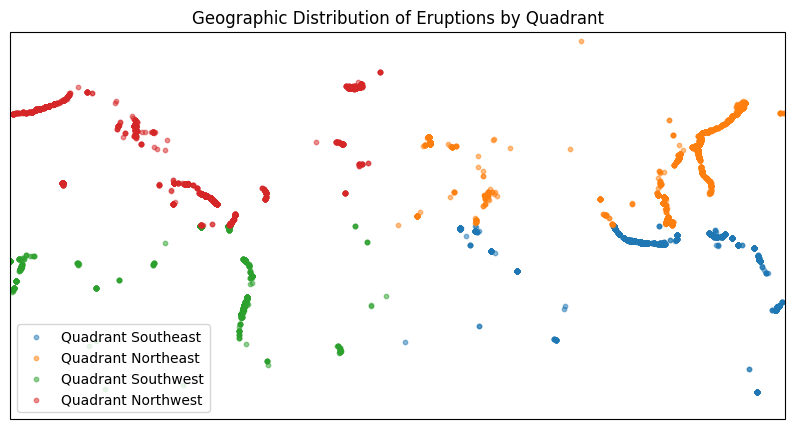

quadrant_label
Northeast    2.074122
Southwest    1.917300
Southeast    1.865716
Northwest    1.856457
Name: vei, dtype: float64


In [35]:

# Create a map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Scatter volcano data by quadrant
for quadrant in eruptions_cleaned['quadrant_label'].unique():
    subset = eruptions_cleaned[eruptions_cleaned['quadrant_label'] == quadrant]
    ax.scatter(subset['longitude'], subset['latitude'], label=f"Quadrant {quadrant}", s=10, alpha=0.5)

ax.legend()
plt.title("Geographic Distribution of Eruptions by Quadrant")
plt.show()

# Group by quadrant and compute the average VEI
average_vei_per_quadrant = eruptions_cleaned.groupby('quadrant_label')['vei'].mean()

# Sort the results to get the quadrant with the highest VEI
sorted_average_vei = average_vei_per_quadrant.sort_values(ascending=False)

# Display the results
print(sorted_average_vei)




In [36]:
correlation = eruptions_cleaned['latitude'].corr(eruptions_cleaned['vei'])
print(f"Correlation between Latitude and VEI: {correlation:.2f}")


Correlation between Latitude and VEI: 0.10


This is interesting, and not what I expected.  The global quadrant that the eruption lies in seems to have the most importance.  Remember, I split the globe into 4 quadrants, NW, NE, SW, and SE.  It appears that this subdivision represents the highest importance in VEI prediction.  I believe this to be due to a specific quadrant having a higher volume of eruptions, and thus more chances to get higher VEI scores.  It appears that Q1 (mapped below), has the highest average VEI.  Q1 is largely the South Pacific, which does have a large amount of volcanic activity.  This could be further explored by breaking down regions even more.

Next in importance comes latitude, although these two variables only have a pearson correlation value of 0.10, which is not really that significant.

Longitude and terrestrial vs marine setting did not really have a ton of significance in this dataset.

Overall, I don't think we were that successful in predicting VEI using this dataset.  I would want more variables, such as tectonic setting perhaps, to add into this analysis.  The good news is that you could add data into this analysis, probably using GIS shapefiles to define regions and tectonic boundaries and such.  However, if may be true that there is not a good predictor of VEI and VEI is very volcano specific.

# Final Pass Questions

**Final pass update:** I added a bit more organization to my notebook taking into account feedback from the class.  I also expanded on my question answers a bit.

**Which method did you like the most?**
In this exercise, I tried to predict VEI based on the volcano variables listed in this dataset.  While I wasn't that successful, I was able to gain some insight into what supervised learning tools work best for this type of questions.  I think that the neural network worked the best for this analysis. Neural networks are great for analyzing complex relationships, which I thought might be the case for this.  While I wasn't that successful, I was able to use results from my neural network to assess the relative importance of the variables I was examining in predicting VEI.  I found that quadrant was the best predictor of VEI (although not very good), which was interesting and would push me to explore this further using some more domain knowledge as well as subdividing these regions even further.

**Which method did you like the least?**
The first part of this exercise I really tried to find a relationship between VEI and marine/terrestrial environment.  I hypothesized that different VEI magnitudes would be found in these environments, but I did not find a connection, signfiying that environment is not a predictor of VEI.  One of the things I did to examine this was to do a logistic regression.  I wanted to do a linear regression but was unsuccessful because this data is categorical instead of continuous, but the linear regression wasn't really that insightful to answer my question further than just finding that more eruptions occurred terrestrially.  There was also a bit of an issue with spatial autocorrelation.  It was very challenging to compare these variables but it was more because they were categorical, and not continuous.  The categorical variables did not really correlate at all with the other data, and this dataset was actually not very informative although it appeared to have a lot of data at the outset.  

**How did you score these supervised models?**  
I scored both my decision tree and logistic regressionusing precision, F-1 score, and recall.  I did a couple of things for my neural network including R2, MSE, MAE, and, most importantly, loss.

**Did the output align with your geologic understanding?**
Largely yes.  VEI is a pretty complicated variable that is dependent on several variables that are hard to track, like tectonic setting, plate speed, continental mass, and more.  Additionally, it seems that VEI is pretty specific to volcanoes.  Although I initially thought this dataset would be more insightful, it turned out to be not very useful and several of the variables (like eruption_category) were not very meaningful.  This would be really interesting to explore in more detail with a more robust dataset that measured more variables.

**What did you want to learn more about?**
I would want more mesaurements of each eruption in context of more geological information.  Eruption type (effusive, phreatomagmatic, etc), magma type, hotspot vs continental margin, etc would be much more useful than most of the data provided in this dataset.

**Did you pre-process your data?**
Just a bit, I had to remove NaNs, and I had to make a few more columns deriving information from the provided variables just to get a bit more geographic nuance into the dataset, which it was really lacking apart from its initial lat/lon.

**Do all models require pre-processing?** Not necessarily, but most machine learning models can benefit from some form of preprocessing.  My analyses needed some pre-processing for optimization.  A big one was that I had categorical variables that I was trying to do numerical anlaysis on, so I had to prepare them for that.
